## Image Segmentation Task 2

In [ ]:
!python -m pip install cityscapesscripts

### Imports

In [1]:
import os
import torch
import zipfile
import numpy as np
from importlib import reload
from cityscapesscripts.download import downloader 
from os.path import join as pjoin
from torchvision import transforms
from datasets.cityscapes import cityscapesDataset
from utils import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

### Setup

In [3]:
torch.manual_seed(253452757)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="6" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
local_path = "./Cityscapes"
pckgs_names = ["gtFine_trainvaltest.zip","leftImg8bit_trainvaltest.zip"]
dir_names = ["gtFine", "leftImg8bit"]

### Dataset and Dataloader

In [6]:
training_data = cityscapesDataset(local_path, split="train")
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

Annotations files processed
Annotations files processed
Annotations files processed


In [7]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}

### Hyperparameters

In [8]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 5
epochs = 16
learning_rate = 0.0002
patience = 7

### Model setup

In [9]:
from networks.r2unet import R2UNet16, R2UNet64

In [10]:
model = R2UNet64().to(device)


In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_f = nn.CrossEntropyLoss(ignore_index = 255)

In [22]:
dataloaders = {
    'train' : torch.utils.data.DataLoader(training_data, batch_size=bs, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(validation_data, batch_size=bs, shuffle=True, num_workers=0)
}

### Training

In [23]:
import training
reload(training)

<module 'training' from '/project/training.py'>

In [24]:
labels = training_data.label_ids()[1:-1]
labels 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [ ]:
model_path = 'models2/fs/15_epochs.pt'
if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [ ]:
model = training.train_early_stopping(model, dataloaders, dataset_sizes, model_path, loss_f, optimizer)

In [ ]:
model = train(model, epochs)

Epoch 0/29 - train loss = 2.5089058665668262
Epoch 0/29 - val loss = 2.1309509716033936
Validation loss decreased (inf --> 2.130951).  Saving model ...
Epoch 1/29 - train loss = 1.1772558706948737
Epoch 1/29 - val loss = 1.5928427267074585
Validation loss decreased (2.130951 --> 1.592843).  Saving model ...
Epoch 2/29 - train loss = 0.8772706839617561
Epoch 2/29 - val loss = 2.3178121185302736
EarlyStopping counter: 1 out of 7
Epoch 3/29 - train loss = 0.8090069799062585
Epoch 3/29 - val loss = 1.9777345533370971
EarlyStopping counter: 2 out of 7
Epoch 4/29 - train loss = 0.7630352093792763
Epoch 4/29 - val loss = 2.31305975151062
EarlyStopping counter: 3 out of 7
Epoch 5/29 - train loss = 0.7311647877372613
Epoch 5/29 - val loss = 2.3028901195526124
EarlyStopping counter: 4 out of 7
Epoch 6/29 - train loss = 0.7086444954311146
Epoch 6/29 - val loss = 2.1918747329711916
EarlyStopping counter: 5 out of 7
Epoch 7/29 - train loss = 0.6849375997871912
Epoch 7/29 - val loss = 2.562229249954224
EarlyStopping counter: 6 out of 7
Epoch 8/29 - train loss = 0.6636786956145984
Epoch 8/29 - val loss = 2.389406723022461
EarlyStopping counter: 7 out of 7
Early stopping

Epoch 0/9 - train loss = 0.953176204396897

Epoch 1/9 - train loss = 0.7165564631213661

Epoch 2/9 - train loss = 0.6445045435128092

Epoch 3/9 - train loss = 0.5909755590583096

Epoch 4/9 - train loss = 0.4886822928150161

Epoch 5/9 - train loss = 0.3495524222860817

Epoch 6/9 - train loss = 0.3233998321435031

Epoch 7/9 - train loss = 0.30781084855063623

Epoch 8/9 - train loss = 0.28303612886356705

Epoch 9/9 - train loss = 0.26729453921067614

### Evaluation

In [11]:
model_path = 'models2/fs/15_epochs.pt'


In [12]:
from evaluation import EvaluationReport

In [ ]:
checkpoint = torch.load(pjoin(model_path, "best_model.pt"))

In [13]:
checkpoint = torch.load(model_path)

In [14]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [25]:
eval_report = EvaluationReport.from_model(dataloaders['val'], model, labels)

In [26]:
eval_report.get_metrics(average="macro")

{'accuracy': 0.9551,
 'sensitivity': 0.3139,
 'specificity': 0.9699,
 'dice_coeff': 0.2328,
 'jaccard_sim': 0.162,
 'f1_score': 0.2328}

In [27]:
from utils import plot_seg_results

In [16]:
dataloader = torch.utils.data.DataLoader(training_data, batch_size=5, shuffle=True, num_workers=0)
images, ground_truths = next(iter(dataloader))
outputs = model(images.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

In [17]:
images = [img.permute(1, 2, 0).numpy() for img in images]
predictions = [training_data.decode_segmap(pred.numpy()) for pred in predictions]
ground_truths = [training_data.decode_segmap(gt.numpy()) for gt in ground_truths]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


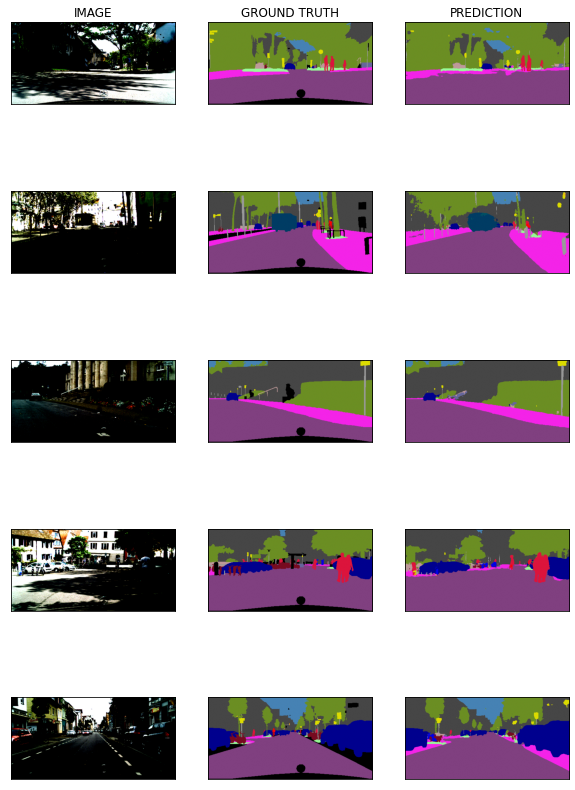

In [18]:
plot_seg_results(images, ground_truths, predictions)